In [2]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt', quiet=True)

True

In [4]:
try:
    # Thử đọc với giả định có header
    train_data = pd.read_csv('/content/drive/MyDrive/train_02.csv')
    test_data = pd.read_csv('/content/drive/MyDrive/test_02.csv')

    # Kiểm tra xem có cột 'Class Index' không
    if 'Class Index' in train_data.columns:
        # Đổi tên cột cho phù hợp
        train_data = train_data.rename(columns={'Class Index': 'class_index'})
        test_data = test_data.rename(columns={'Class Index': 'class_index'})

    # Tìm cột mô tả
    desc_column = [col for col in train_data.columns if col != 'class_index'][0]
    train_data = train_data.rename(columns={desc_column: 'description'})
    test_data = test_data.rename(columns={desc_column: 'description'})

except Exception as e:
    print(f"Thử đọc lại với định dạng khác: {e}")
    # Thử lại với định dạng không có header
    train_data = pd.read_csv('train_02.csv', header=None, names=['class_index', 'description'])
    test_data = pd.read_csv('test_02.csv', header=None, names=['class_index', 'description'])

In [5]:
if isinstance(train_data['class_index'].iloc[0], str) and train_data['class_index'].iloc[0].lower() in ['class index', 'class_index', 'classindex']:
    print("Phát hiện dòng tiêu đề, loại bỏ dòng đầu tiên...")
    train_data = train_data.iloc[1:].reset_index(drop=True)
    test_data = test_data.iloc[1:].reset_index(drop=True)

In [6]:
print(f"- Tập huấn luyện: {len(train_data)} mẫu")
print(f"- Tập kiểm thử: {len(test_data)} mẫu")
print("\nCác cột trong dữ liệu:")
print(train_data.columns.tolist())
print("\nXem 5 mẫu đầu tiên:")
print(train_data.head(5))

- Tập huấn luyện: 120000 mẫu
- Tập kiểm thử: 7600 mẫu

Các cột trong dữ liệu:
['class_index', 'description']

Xem 5 mẫu đầu tiên:
   class_index                                        description
0            3  Reuters - Short-sellers, Wall Street's dwindli...
1            3  Reuters - Private investment firm Carlyle Grou...
2            3  Reuters - Soaring crude prices plus worries\ab...
3            3  Reuters - Authorities have halted oil export\f...
4            3  AFP - Tearaway world oil prices, toppling reco...


In [7]:
print("\nPhân bố lớp trong tập huấn luyện:")
class_mapping = {'1': 'World', '2': 'Sports', '3': 'Business', '4': 'Science and Technology'}

train_class_str = []
for label in train_data['class_index']:
    try:
        # Nếu là số, chuyển thành chuỗi
        train_class_str.append(str(int(label)))
    except:
        # Nếu đã là chuỗi, kiểm tra giá trị
        if isinstance(label, str):
            if label.lower() == 'world':
                train_class_str.append('1')
            elif label.lower() == 'sports':
                train_class_str.append('2')
            elif label.lower() == 'business':
                train_class_str.append('3')
            elif label.lower() in ['science and technology', 'science', 'technology']:
                train_class_str.append('4')
            else:
                train_class_str.append(label)

train_class_counts = pd.Series(train_class_str).value_counts().sort_index()
for idx, count in train_class_counts.items():
    if idx in class_mapping:
        print(f"Lớp {idx} ({class_mapping[idx]}): {count} mẫu")
    else:
        print(f"Lớp {idx} (Không xác định): {count} mẫu")


Phân bố lớp trong tập huấn luyện:
Lớp 1 (World): 30000 mẫu
Lớp 2 (Sports): 30000 mẫu
Lớp 3 (Business): 30000 mẫu
Lớp 4 (Science and Technology): 30000 mẫu


In [8]:
def build_vocab(texts, max_vocab_size=10000):
    word_counter = Counter()
    for text in texts:
        tokens = word_tokenize(text.lower())
        word_counter.update(tokens)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in word_counter.most_common(max_vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

def text_to_indices(text, vocab):
    tokens = word_tokenize(text.lower())
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

In [9]:
vocab = build_vocab(train_data['description'].values)
vocab_size = len(vocab)
print(f"\nKích thước từ điển: {vocab_size} từ")


Kích thước từ điển: 10000 từ


In [10]:
max_sequence_length = 100  # Độ dài tối đa cho mỗi câu
embedding_dim = 128  # Kích thước vector embedding
hidden_dim = 128  # Kích thước hidden state của LSTM
num_classes = 4  # Số lượng chủ đề cần phân loại
batch_size = 32  # Kích thước batch
num_epochs = 10  # Số epoch

In [11]:
train_labels = []
for label in train_data['class_index']:
    try:
        # Cố gắng chuyển đổi thành số nguyên và trừ 1
        train_labels.append(int(label) - 1)
    except ValueError:
        # Nếu không phải số nguyên, kiểm tra giá trị chuỗi
        if isinstance(label, str) and label.lower() in ['world', '1']:
            train_labels.append(0)
        elif isinstance(label, str) and label.lower() in ['sports', '2']:
            train_labels.append(1)
        elif isinstance(label, str) and label.lower() in ['business', '3']:
            train_labels.append(2)
        elif isinstance(label, str) and label.lower() in ['science and technology', 'science', 'technology', '4']:
            train_labels.append(3)
        else:
            # Giá trị không hợp lệ, gán giá trị mặc định
            print(f"Giá trị không hợp lệ: {label}, gán nhãn 0")
            train_labels.append(0)

In [12]:
test_labels = []
for label in test_data['class_index']:
    try:
        test_labels.append(int(label) - 1)
    except ValueError:
        if isinstance(label, str) and label.lower() in ['world', '1']:
            test_labels.append(0)
        elif isinstance(label, str) and label.lower() in ['sports', '2']:
            test_labels.append(1)
        elif isinstance(label, str) and label.lower() in ['business', '3']:
            test_labels.append(2)
        elif isinstance(label, str) and label.lower() in ['science and technology', 'science', 'technology', '4']:
            test_labels.append(3)
        else:
            print(f"Giá trị không hợp lệ: {label}, gán nhãn 0")
            test_labels.append(0)


In [13]:
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [14]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        indices = text_to_indices(text, self.vocab)

        # Cắt ngắn hoặc padding để đạt độ dài cố định
        if len(indices) > self.max_len:
            indices = indices[:self.max_len]
        else:
            # Padding với 0 (chỉ số của <PAD>)
            indices = indices + [0] * (self.max_len - len(indices))

        return torch.tensor(indices, dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)


In [15]:
train_dataset = NewsDataset(train_data['description'].values, train_labels, vocab, max_sequence_length)
test_dataset = NewsDataset(test_data['description'].values, test_labels, vocab, max_sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [16]:
class NewsClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_classes, dropout_rate=0.3):
        super(NewsClassifier, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Spatial Dropout (dropout trên chiều đặc trưng)
        self.spatial_dropout = nn.Dropout2d(dropout_rate)

        # 3 lớp LSTM (stacked)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)  # *2 vì bidirectional
        self.dropout = nn.Dropout(dropout_rate)
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length)

        # Embedding layer
        x = self.embedding(x)  # (batch_size, sequence_length, embedding_dim)

        # Áp dụng spatial dropout
        x = x.permute(0, 2, 1)  # (batch_size, embedding_dim, sequence_length)
        x = self.spatial_dropout(x)
        x = x.permute(0, 2, 1)  # (batch_size, sequence_length, embedding_dim)

        # LSTM layers
        lstm_out, _ = self.lstm(x)  # (batch_size, sequence_length, hidden_dim*2)

        # Lấy output của timestep cuối cùng
        lstm_out = lstm_out[:, -1, :]  # (batch_size, hidden_dim*2)

        # Fully connected layers
        out = self.fc1(lstm_out)
        out = self.bn(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)

        return out

In [17]:
def print_model_info(model, max_len):
    """In thông tin chi tiết về mô hình"""
    print("\n" + "="*80)
    print("THÔNG TIN CHI TIẾT MÔ HÌNH")
    print("="*80)

    # Bảng thông tin các lớp
    print("\nBẢNG THÔNG TIN CÁC LỚP TRONG MÔ HÌNH:")
    print("-" * 120)
    print(f"{'Tên lớp':<20} {'Hàm kích hoạt':<15} {'Đầu vào':<25} {'Đầu ra':<25} {'Timesteps':<12} {'Tham số':<15}")
    print("-" * 120)

    # Embedding Layer
    embed_params = model.embedding.weight.numel()
    print(f"{'Embedding':<20} {'None':<15} {f'({model.embedding.num_embeddings})':<25} {f'({model.embedding.num_embeddings}, {model.embedding.embedding_dim})':<25} {'N/A':<12} {embed_params:<15}")

    # Spatial Dropout
    print(f"{'Spatial Dropout':<20} {'None':<15} {f'({max_len}, {model.embedding.embedding_dim})':<25} {f'({max_len}, {model.embedding.embedding_dim})':<25} {'N/A':<12} {'0':<15}")

    # LSTM Layer (Bidirectional)
    lstm_params = sum(p.numel() for p in model.lstm.parameters())
    print(f"{'LSTM':<20} {'tanh, sigmoid':<15} {f'({max_len}, {model.embedding.embedding_dim})':<25} {f'({max_len}, {model.lstm.hidden_size*2})':<25} {max_len:<12} {lstm_params:<15}")

    # Dropout
    print(f"{'Dropout':<20} {'None':<15} {f'({model.lstm.hidden_size*2})':<25} {f'({model.lstm.hidden_size*2})':<25} {'N/A':<12} {'0':<15}")

    # FC1 Layer
    fc1_params = model.fc1.weight.numel() + model.fc1.bias.numel()
    print(f"{'FC1':<20} {'ReLU':<15} {f'({model.lstm.hidden_size*2})':<25} {f'({model.fc1.out_features})':<25} {'N/A':<12} {fc1_params:<15}")

    # BatchNorm Layer
    bn_params = model.bn.weight.numel() + model.bn.bias.numel()
    print(f"{'BatchNorm':<20} {'None':<15} {f'({model.fc1.out_features})':<25} {f'({model.fc1.out_features})':<25} {'N/A':<12} {bn_params:<15}")

    # FC2 Layer
    fc2_params = model.fc2.weight.numel() + model.fc2.bias.numel()
    print(f"{'FC2':<20} {'None':<15} {f'({model.fc1.out_features})':<25} {f'({model.fc2.out_features})':<25} {'N/A':<12} {fc2_params:<15}")

    print("-" * 120)

    # Tổng số tham số
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTỔNG SỐ THAM SỐ: {total_params:,}")
    print(f"THAM SỐ CÓ THỂ HUẤN LUYỆN: {trainable_params:,}")

    # Chi tiết tham số từng lớp
    print(f"\nCHI TIẾT SỐ THAM SỐ TỪNG LỚP:")
    print("-" * 50)
    for name, param in model.named_parameters():
        print(f"{name:<35}: {param.numel():>10,}")
    print("-" * 50)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Sử dụng thiết bị: {device}")

model = NewsClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=3,  # 3 lớp LSTM theo yêu cầu
    num_classes=num_classes
).to(device)

print_model_info(model, max_sequence_length)

Sử dụng thiết bị: cuda

THÔNG TIN CHI TIẾT MÔ HÌNH

BẢNG THÔNG TIN CÁC LỚP TRONG MÔ HÌNH:
------------------------------------------------------------------------------------------------------------------------
Tên lớp              Hàm kích hoạt   Đầu vào                   Đầu ra                    Timesteps    Tham số        
------------------------------------------------------------------------------------------------------------------------
Embedding            None            (10000)                   (10000, 128)              N/A          1280000        
Spatial Dropout      None            (100, 128)                (100, 128)                N/A          0              
LSTM                 tanh, sigmoid   (100, 128)                (100, 256)                100          1054720        
Dropout              None            (256)                     (256)                     N/A          0              
FC1                  ReLU            (256)                     (128)          

In [19]:
total_params = 0
print("\nThống kê tham số của mô hình:")
for name, param in model.named_parameters():
    param_count = param.numel()
    total_params += param_count
    print(f"{name}: {param_count:,} tham số")
print(f"Tổng số tham số: {total_params:,}")


Thống kê tham số của mô hình:
embedding.weight: 1,280,000 tham số
lstm.weight_ih_l0: 65,536 tham số
lstm.weight_hh_l0: 65,536 tham số
lstm.bias_ih_l0: 512 tham số
lstm.bias_hh_l0: 512 tham số
lstm.weight_ih_l0_reverse: 65,536 tham số
lstm.weight_hh_l0_reverse: 65,536 tham số
lstm.bias_ih_l0_reverse: 512 tham số
lstm.bias_hh_l0_reverse: 512 tham số
lstm.weight_ih_l1: 131,072 tham số
lstm.weight_hh_l1: 65,536 tham số
lstm.bias_ih_l1: 512 tham số
lstm.bias_hh_l1: 512 tham số
lstm.weight_ih_l1_reverse: 131,072 tham số
lstm.weight_hh_l1_reverse: 65,536 tham số
lstm.bias_ih_l1_reverse: 512 tham số
lstm.bias_hh_l1_reverse: 512 tham số
lstm.weight_ih_l2: 131,072 tham số
lstm.weight_hh_l2: 65,536 tham số
lstm.bias_ih_l2: 512 tham số
lstm.bias_hh_l2: 512 tham số
lstm.weight_ih_l2_reverse: 131,072 tham số
lstm.weight_hh_l2_reverse: 65,536 tham số
lstm.bias_ih_l2_reverse: 512 tham số
lstm.bias_hh_l2_reverse: 512 tham số
fc1.weight: 32,768 tham số
fc1.bias: 128 tham số
bn.weight: 128 tham số
bn.bi

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [21]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [22]:
train_losses = []
valid_losses = []
train_accuracy = []
val_accuracy = []

def train_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc, all_preds, all_labels

In [23]:
print("\nBắt đầu huấn luyện mô hình...")
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Huấn luyện một epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracy.append(train_acc)

    # Đánh giá trên tập validation
    val_loss, val_acc, _, _ = evaluate(model, test_loader, criterion, device)
    valid_losses.append(val_loss)
    val_accuracy.append(val_acc)

    # Điều chỉnh learning rate
    scheduler.step(val_loss)

    # Lưu mô hình tốt nhất
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_news_classifier.pth')

    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')



Bắt đầu huấn luyện mô hình...


/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


Epoch 1/10: Train Loss: 1.3962, Train Acc: 0.2496 | Val Loss: 1.3870, Val Acc: 0.2500
Epoch 2/10: Train Loss: 1.3889, Train Acc: 0.2504 | Val Loss: 1.3840, Val Acc: 0.2532
Epoch 3/10: Train Loss: 1.1081, Train Acc: 0.4274 | Val Loss: 0.5778, Val Acc: 0.7663
Epoch 4/10: Train Loss: 0.4374, Train Acc: 0.8434 | Val Loss: 0.3155, Val Acc: 0.8878
Epoch 5/10: Train Loss: 0.3179, Train Acc: 0.8914 | Val Loss: 0.2805, Val Acc: 0.9026
Epoch 6/10: Train Loss: 0.2747, Train Acc: 0.9065 | Val Loss: 0.2671, Val Acc: 0.9028
Epoch 7/10: Train Loss: 0.2465, Train Acc: 0.9151 | Val Loss: 0.2634, Val Acc: 0.9093
Epoch 8/10: Train Loss: 0.2261, Train Acc: 0.9216 | Val Loss: 0.2539, Val Acc: 0.9141
Epoch 9/10: Train Loss: 0.2108, Train Acc: 0.9270 | Val Loss: 0.2619, Val Acc: 0.9150
Epoch 10/10: Train Loss: 0.1978, Train Acc: 0.9321 | Val Loss: 0.2682, Val Acc: 0.9103


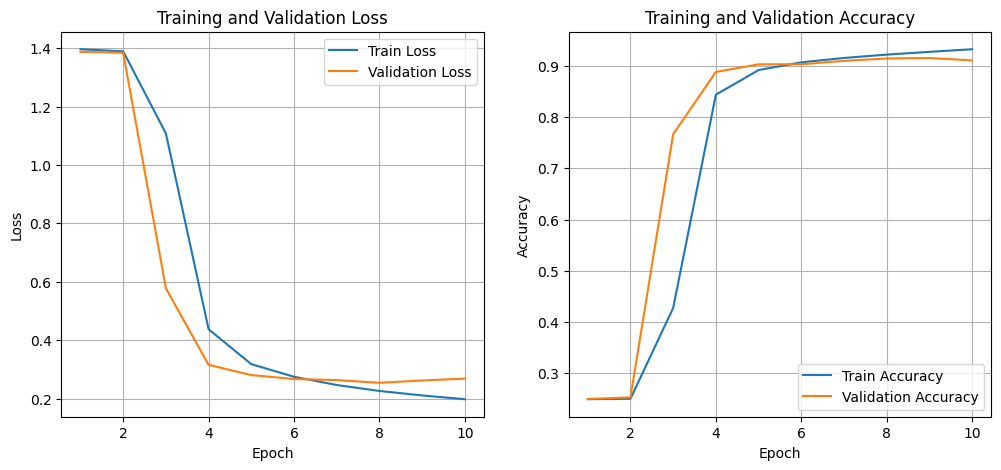

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracy, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)



In [25]:
print("\nĐánh giá mô hình trên tập test:")
model.load_state_dict(torch.load('best_news_classifier.pth'))
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion, device)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')



Đánh giá mô hình trên tập test:
Test Loss: 0.2539, Test Accuracy: 0.9141


In [26]:
print("\nBáo cáo phân loại chi tiết:")
class_names = [class_mapping[str(i+1)] for i in range(num_classes)]
print(classification_report(test_labels, test_preds, target_names=class_names))


Báo cáo phân loại chi tiết:
                        precision    recall  f1-score   support

                 World       0.92      0.92      0.92      1900
                Sports       0.96      0.98      0.97      1900
              Business       0.91      0.85      0.88      1900
Science and Technology       0.87      0.90      0.88      1900

              accuracy                           0.91      7600
             macro avg       0.91      0.91      0.91      7600
          weighted avg       0.91      0.91      0.91      7600



In [27]:
model.eval()

# Lấy ngẫu nhiên 10 mẫu từ tập test
test_samples = np.random.choice(len(test_dataset), 10, replace=False)

with torch.no_grad():
    for idx in test_samples:
        inputs, labels = test_dataset[idx]
        inputs = inputs.unsqueeze(0).to(device)  # Thêm chiều batch

        outputs = model(inputs)
        _, predicted = outputs.max(1)

        # Xử lý lấy class_mapping cho dự đoán và thực tế
        try:
            predicted_class_str = str(predicted.item() + 1)
            actual_class_str = str(labels.item() + 1)
            predicted_name = class_mapping.get(predicted_class_str, f"Không xác định ({predicted_class_str})")
            actual_name = class_mapping.get(actual_class_str, f"Không xác định ({actual_class_str})")
        except:
            predicted_class_str = str(predicted.item())
            actual_class_str = str(labels.item())
            predicted_name = f"Lớp {predicted_class_str}"
            actual_name = f"Lớp {actual_class_str}"

        print(f"Mẫu {idx}:")
        print(f"Văn bản: {test_data.iloc[idx]['description']}")
        print(f"Nhãn thực tế: {actual_class_str} ({actual_name})")
        print(f"Dự đoán: {predicted_class_str} ({predicted_name})")
        print("-" * 100)

/usr/local/lib/python3.11/dist-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


Mẫu 2468:
Văn bản: SAN FRANCISCO - Shawn Green can sit out Saturday knowing he was a huge help to the Dodgers during their crucial series against San Francisco. Green hit a two-run homer in Los Angeles' 3-2 victory over the Giants on Friday night, a day before the first baseman will miss a game to observe the Jewish holiday Yom Kippur...
Nhãn thực tế: 1 (World)
Dự đoán: 1 (World)
----------------------------------------------------------------------------------------------------
Mẫu 2101:
Văn bản: At a time when more people are cured of cancer than ever before, fewer doctors seem willing to say so. They call the cancer undetectable, or in remission. They tell patients they can quit seeing cancer specialists. They quote statistics and say chances are slim that the disease will come back.
Nhãn thực tế: 4 (Science and Technology)
Dự đoán: 3 (Business)
----------------------------------------------------------------------------------------------------
Mẫu 5777:
Văn bản: NEW YORK: Boeing Co